In [1]:
import time
import random
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import uuid
import pandas as pd
import numpy as np

In [2]:
#reference: https://jrtechs.net/data-science/implementing-a-quadtree-in-python

## Node class

In [3]:
# Node class is a rectangle in the quardtree
# with (x0, y0) as coordinates, w as width, h as height
class Node():
    def __init__(self, x0, y0, w, h):
        self.x0 = x0
        self.y0 = y0
        self.width = w
        self.height = h
        self.children = []
        # the unique id for each node
        self.id = uuid.uuid4().hex[:4]

    def get_location(self):
        return (self.x0, self.yo)
    
    def get_width(self):
        return self.width
    
    def get_height(self):
        return self.height
    
    def get_children(self):
        return self.children

## QTree class

In [4]:
# QTree class which can do the divide and graph of quardtree
class QTree():
    def __init__(self):
        self.root = Node(0, 0, 10, 10)
        
    def subdivide(self, node):
        w_ = float(node.width/2)
        h_ = float(node.height/2)
        x1 = Node(node.x0, node.y0, w_, h_)
        x2 = Node(node.x0, node.y0+h_, w_, h_)
        x3 = Node(node.x0 + w_, node.y0, w_, h_)
        x4 = Node(node.x0+w_, node.y0+h_, w_, h_)
        node.children = [x1, x2, x3, x4]
        
    def weld(self, node):
        node.children = []
        
    def graph(self):
        fig, ax = plt.subplots(figsize=(8, 8))
        plt.title("Quadtree")
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        c = find_children(self.root)
        print("Number of segments: %d" %len(c))
        areas = set()
        for el in c:
            areas.add(el.width*el.height)
        print("Minimum segment area: %.3f units" %min(areas))
        for n in c:
            #print((n.x0, n.y0), n.width, n.height)
            rect = patches.Rectangle((n.x0, n.y0), n.width, n.height, fill=False)
            ax.add_patch(rect)
        patches_list = ax.patches
        plt.show()

## Essential methods about finding children and parents, the size distribution and plotting

### Method about find the children and parents

In [5]:
# FIND the list of all nodes that can be divide(the leaf)
def find_children(node):
    if not node.children:
        return [node]
    else:
        children = []
        for child in node.children:
            children +=(find_children(child))
    return children

# FIND the list of all nodes that can be fuse(the parent)
def find_parents(node):
    if len(node.children) != 4:
        return []
    else: 
        parent = [node]
        for child in node.children:
            parent += find_parents(child)
        return parent


### Method about find the size distribution and plotting

In [6]:
# FIND the dictionary of leave nodes' size(sorted)
from collections import OrderedDict      # ordered dictionary is used for sorted the size

def find_size(node):
    if not node.children:
        size = node.width * node.height
        return {size: 1}
    else:
        sizes = {}
        for child in node.children:
            child_sizes = find_size(child)
            for child_size, count in child_sizes.items():
                if child_size in sizes:
                    sizes[child_size] += count
                else:
                    sizes[child_size] = count
        sorted_sizes = OrderedDict(sorted(sizes.items()))
        return sorted_sizes

# plot the size distribution
def plot_size_distribution(size_distribution):
    sizes = list(size_distribution.keys())
    counts = list(size_distribution.values())
    print("sizes: ", sizes)
    print("counts: ",counts)
    plt.plot(sizes, counts, marker='o', linestyle='-')
#    plt.bar(sizes, counts)
    plt.xlabel('Node Size')
#    plt.xticks(rotation=90)
    plt.ylabel('Count')
    plt.title('Size Distribution of ice floes')
    plt.show()

## Visualization (not required)

In [7]:
# sudo apt install -y graphviz
# pip3 install graphviz
from graphviz import Graph, Digraph

In [8]:
# FIND the dictionary of all nodes id that can be divide(the leaf)
def find_children_id(node):
    if not node.children:
        return [node.id]
    else:
        children = []
        for child in node.children:
            children +=(find_children_id(child))
    return children

# FIND the dictionary of all nodes id that can be fuse(the parent)
def find_parents_id(node):
    if len(node.children) != 4:
        return []
    else: 
        parent = [node.id]
        for child in node.children:
            parent += find_parents_id(child)
        return parent

In [9]:
# draw the nodes in a tree graph
def tree_graph(node, g):
    if node.children == []:
        return g
    for child in node.children:
        g.edge(node.id, child.id)
        tree_graph(child, g)
    return g

## Example

In [10]:
import random
# example of using QTreee 
quard = QTree()

# Divide random times between 0 and 5
for i in range(20000):
    # Divide random parent node
    index = random.randint(0,len(find_children(quard.root))-1)
    #print("Divide: ", find_children(quard.root)[index].id)
    quard.subdivide(find_children(quard.root)[index])

# # Weld random times between 0 and 5
# for i in range(random.randint(0, 10)):
#     # Weld random child node to a parent node
#     if len(find_parents(quard.root)) == 0:
#         break
#     if len(find_parents(quard.root)) == 1:
#         #print("Weld the children of: ", find_parents(quard.root)[0].id)
#         quard.weld(find_parents(quard.root)[0])
#         break
#     index = random.randint(0,len(find_parents(quard.root))-1)
#     #print("Weld the children of: ", find_parents(quard.root)[index].id)
#     quard.weld(find_parents(quard.root)[index])
#quard.graph() 

Number of segments: 60001
Minimum segment area: 0.000 units


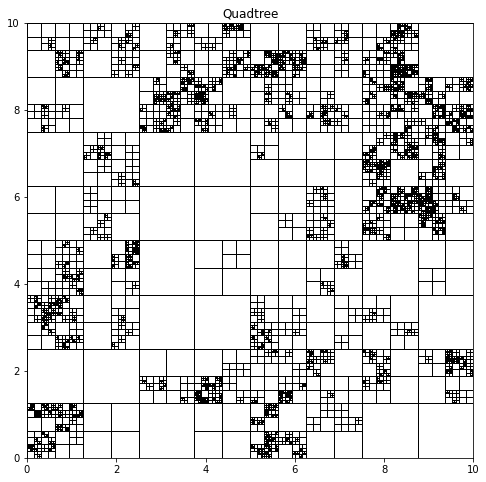

In [13]:
quard.graph() 

sizes:  [2.220446049250313e-14, 8.881784197001252e-14, 3.552713678800501e-13, 1.4210854715202004e-12, 5.6843418860808015e-12, 2.2737367544323206e-11, 9.094947017729282e-11, 3.637978807091713e-10, 1.4551915228366852e-09, 5.820766091346741e-09, 2.3283064365386963e-08, 9.313225746154785e-08, 3.725290298461914e-07, 1.4901161193847656e-06, 5.9604644775390625e-06, 2.384185791015625e-05, 9.5367431640625e-05, 0.0003814697265625, 0.00152587890625, 0.006103515625, 0.0244140625, 0.09765625, 0.390625, 1.5625]
counts:  [16, 84, 190, 415, 771, 1134, 1581, 2308, 3135, 3758, 4517, 5200, 5856, 6274, 6174, 5719, 4917, 3701, 2150, 1208, 611, 197, 68, 17]


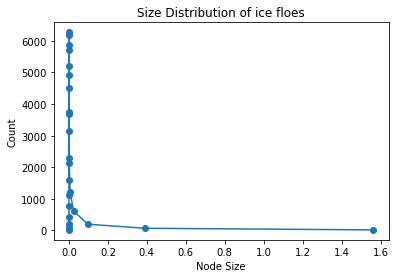

In [11]:
# the size distribution of the tree
size_distribution = find_size(quard.root)
plot_size_distribution(size_distribution)

## Simulation

### A simple random choice based on probability of divide, weld rate

In [ ]:
class Python_Switch:
    def behave(self, num, quard):
        default = "Error input: input should be integer from 0 to 2"
        self.quard = quard
        return getattr(self, 'case_' + str(num), lambda: default)()
    
    def case_0(self):
        # nothing happen
        return 

    def case_1(self):
        # divde
        index = random.randint(0,len(find_children(quard.root))-1)
        self.quard.subdivide(find_children(quard.root)[index])

    
    def case_2(self):
        if len(find_parents(quard.root)) == 1 or len(find_parents(quard.root)) == 0:
            return
        # weld
        index = random.randint(0,len(find_parents(quard.root))-1)
        self.quard.weld(find_parents(quard.root)[index])

In [ ]:
# 0: nothing happen
# 1: fracture
# 2: weld
def spilt_weld_simulate(spilt_rate, weld_rate):
    quard_example = QTree()
    if spilt_rate + weld_rate > 1:
        print("Error: invalid input, possibility larger than 1")
    nothing_rate = 1 - spilt_rate - weld_rate
    population = [0,1,2]
    weights = [nothing_rate, spilt_rate, weld_rate]
    for i in range(10000000):
        num = random.choices(population, weights)[0]
        switch = Python_Switch()
        switch.behave(num, quard_example)
    size_distribution = find_size(quard.root)
    plot_size_distribution(size_distribution)
    quard.graph()

In [ ]:
spilt_weld_simulate(0.554,0.3)

## Check whether the size distribution is a poisson distribtuion

In [17]:
# install by `pip install powerlaw`
import powerlaw
import matplotlib.pyplot as plt

def check_power_law_distribution(size_distribution):
    sizes = list(size_distribution.keys())
    counts = list(size_distribution.values())

    # Fit power law model
    fit = powerlaw.Fit(sizes, xmin=min(sizes))

    # Plot the distribution and power law fit
    fit.plot_ccdf(color='r', linewidth=2)
    fit.power_law.plot_ccdf(color='g', linestyle='--', ax=plt.gca())

    # Perform goodness-of-fit test
    R, p_value = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)

    if p_value < 0.05:
        print("The size distribution is not a good fit for a power law distribution.")
    else:
        print("The size distribution is a good fit for a power law distribution.")

    plt.xlabel('Node Size')
    plt.ylabel('Complementary Cumulative Distribution Function (CCDF)')
    plt.title('Size Distribution and Power Law Fit')
    plt.show()

The size distribution is not a good fit for a power law distribution.


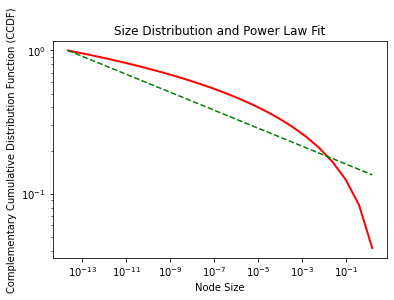

In [18]:
# Usage:
size_distribution = find_size(quard.root)
check_power_law_distribution(size_distribution)